# Information Retrieval Project

## Libraries

In [1]:
!pip install optuna
!pip install scikit-learn



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, recall_score, multilabel_confusion_matrix, accuracy_score, jaccard_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import optuna



In [4]:
from transformers import BertTokenizer, BertForSequenceClassification

## Getting DataSet

In [5]:
## carga de los datos y etiquetas

#test dataset
test_set = "/content/drive/MyDrive/Colab Notebooks/INFORET/arguments-test.tsv"
test_label = "/content/drive/MyDrive/Colab Notebooks/INFORET/labels-test.tsv"
test_arg = pd.read_csv(test_set, delimiter='\t')
test_label = pd.read_csv(test_label, delimiter= '\t')
df_test = pd.merge(test_arg, test_label, how='left', on="Argument ID")

#training dataset
training_set = "/content/drive/MyDrive/Colab Notebooks/INFORET/arguments-training.tsv"
training_label = "/content/drive/MyDrive/Colab Notebooks/INFORET/labels-training.tsv"
training_arg = pd.read_csv(training_set, delimiter='\t')
training_label = pd.read_csv(training_label, delimiter= '\t')
df_training = pd.merge(training_arg, training_label, how='left', on="Argument ID")

#validation dataset
validation_set = "/content/drive/MyDrive/Colab Notebooks/INFORET/arguments-validation.tsv"
validation_label = "/content/drive/MyDrive/Colab Notebooks/INFORET/labels-validation.tsv"
validation_arg = pd.read_csv(validation_set, delimiter='\t')
validation_label = pd.read_csv(validation_label, delimiter= '\t')
df_validation = pd.merge(validation_arg, validation_label, how='left', on="Argument ID")



In [6]:
model_name = "bert-base-uncased"
tokenizer= BertTokenizer.from_pretrained(model_name)

def max_length(df):
  data = df.copy()
  data['text'] = data['Conclusion'] + " " + data['Premise'] + " " + data['Stance']
  data['length'] = data['text'].apply(lambda x: len(tokenizer.encode(x)))
  max_length = data['length'].max()
  return max_length

length_test = max_length(df_test)
length_train = max_length(df_training)
length_validation = max_length(df_validation)

MAX_LEN = max(length_test, length_train, length_validation)
MAX_LEN

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

189

In [7]:
def dataset_builder(df):
  data = df.copy()
  data['Contexto'] = data['Stance'] + " " + data['Conclusion'] + " " + data['Premise']
  data.drop(labels=['Argument ID','Conclusion','Premise','Stance'], axis=1, inplace=True)
  data = data[['Contexto', 'Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity' ]]
  labels_data = data.iloc[:, 1:]
  tokenized_texts = [tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=MAX_LEN) for text in data['Contexto']]
  input_ids = torch.cat([item['input_ids'] for item in tokenized_texts], dim=0)
  attention_masks = torch.cat([item['attention_mask'] for item in tokenized_texts], dim=0)
  token_type_ids = torch.cat([item['token_type_ids'] for item in tokenized_texts], dim=0)
  print(type(labels_data))
  print(labels_data.shape)
  labels = torch.tensor(labels_data.values, dtype=torch.float32)
  dataset = TensorDataset(input_ids, attention_masks, labels)
  return dataset


## Taxonamy of the data

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dataset(df):
  value_columns = df.columns[4:]

  frequencies = df[value_columns].sum().sort_values(ascending=False)

  # Analysis Co-ocurrences
  co_occurrence_matrix = df[value_columns].T.dot(df[value_columns])

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

  # Visualization of frequencies
  frequencies.plot(kind='bar', ax=ax[0])
  ax[0].set_title('Frecuencia de Valores')
  ax[0].set_xlabel('Valor')
  ax[0].set_ylabel('Frecuencia')

  # Visualization of Co-ocurrences
  sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax[1])
  ax[1].set_title('co_occurrence_matrix')
  ax[1].set_xlabel('Valor')
  ax[1].set_ylabel('Valor')

  # layout adjustment
  plt.tight_layout()
  plt.show()

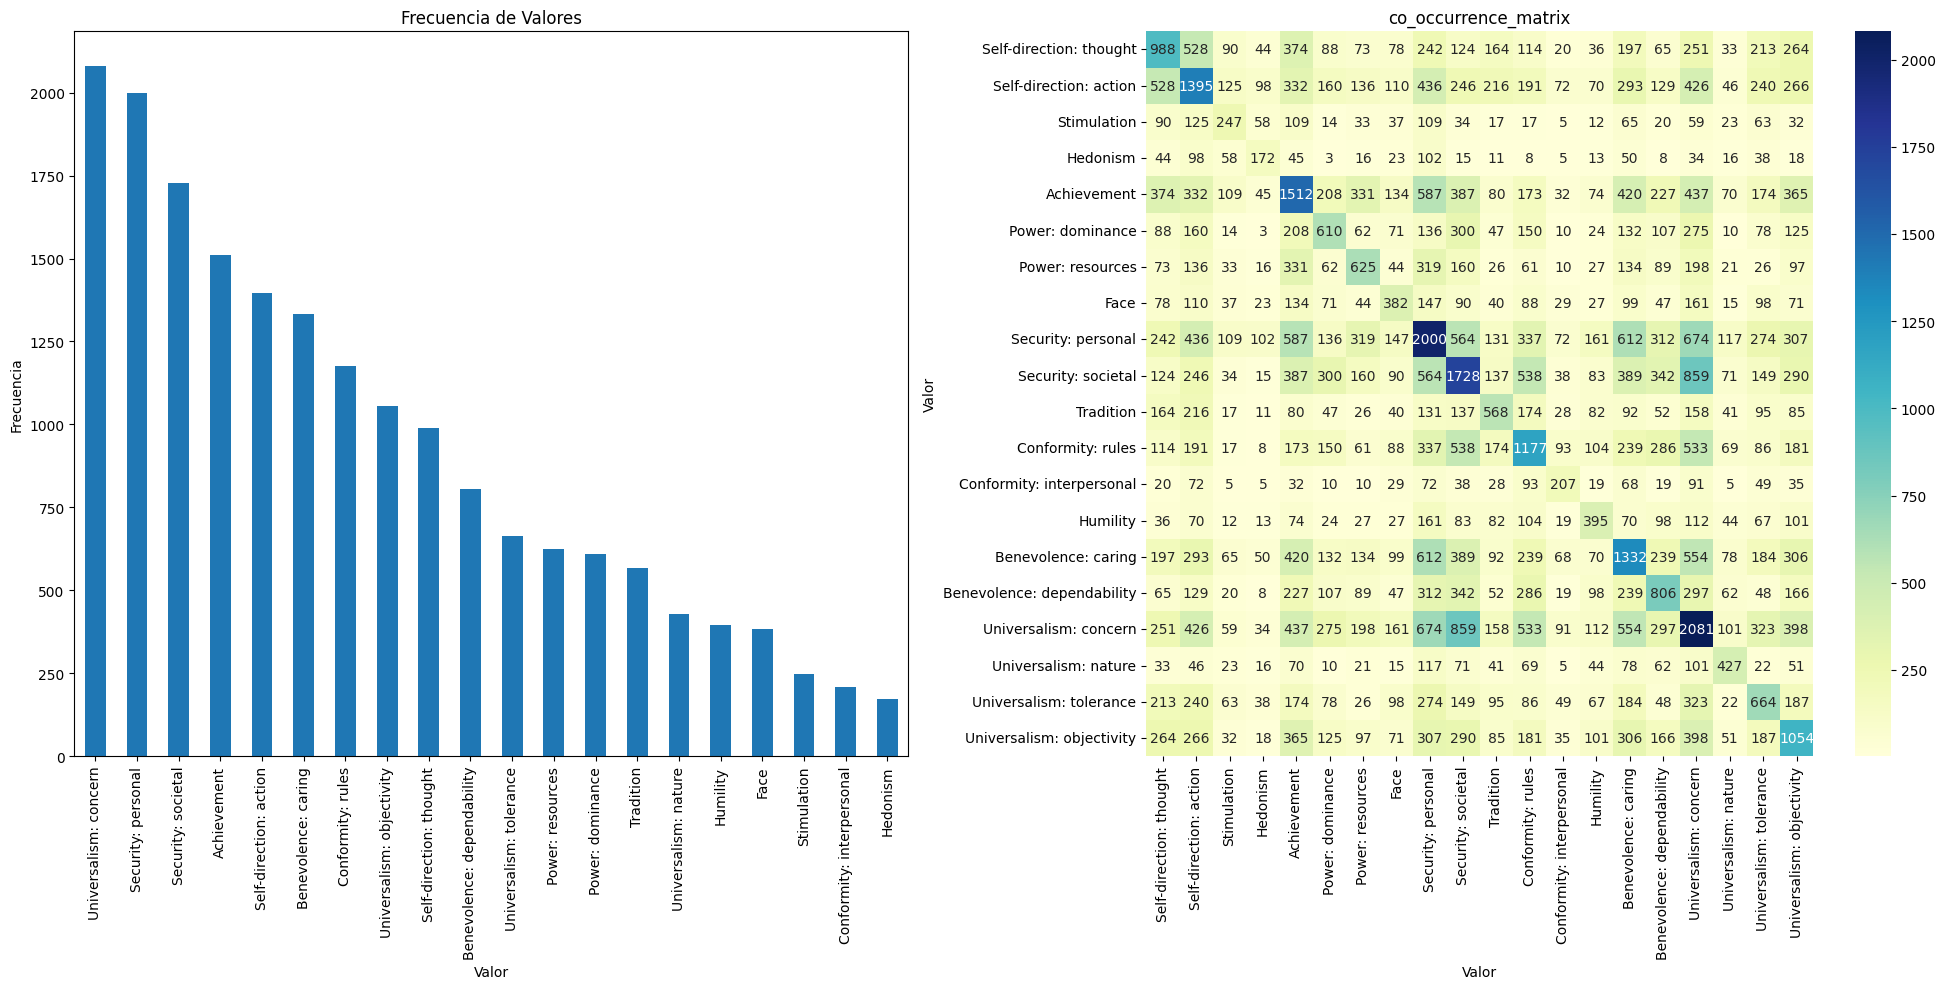

In [9]:
plot_dataset(df_training)

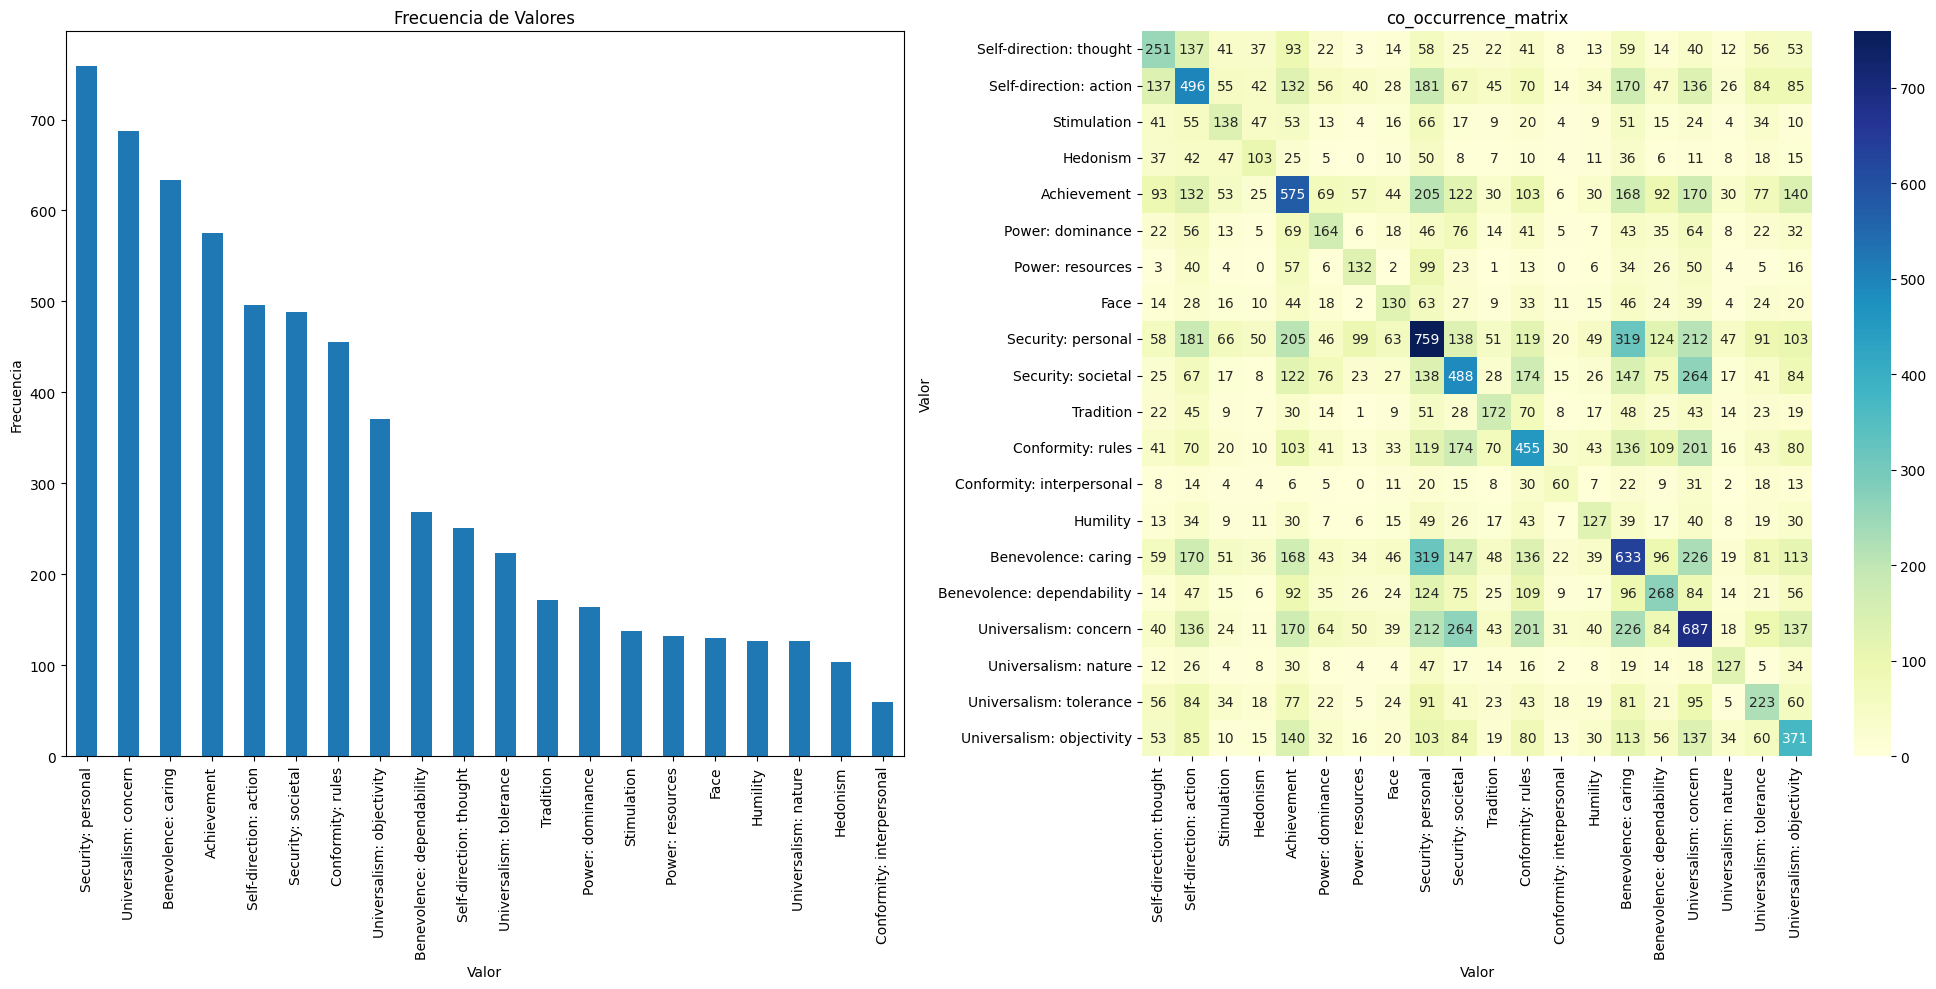

In [10]:
plot_dataset(df_validation)

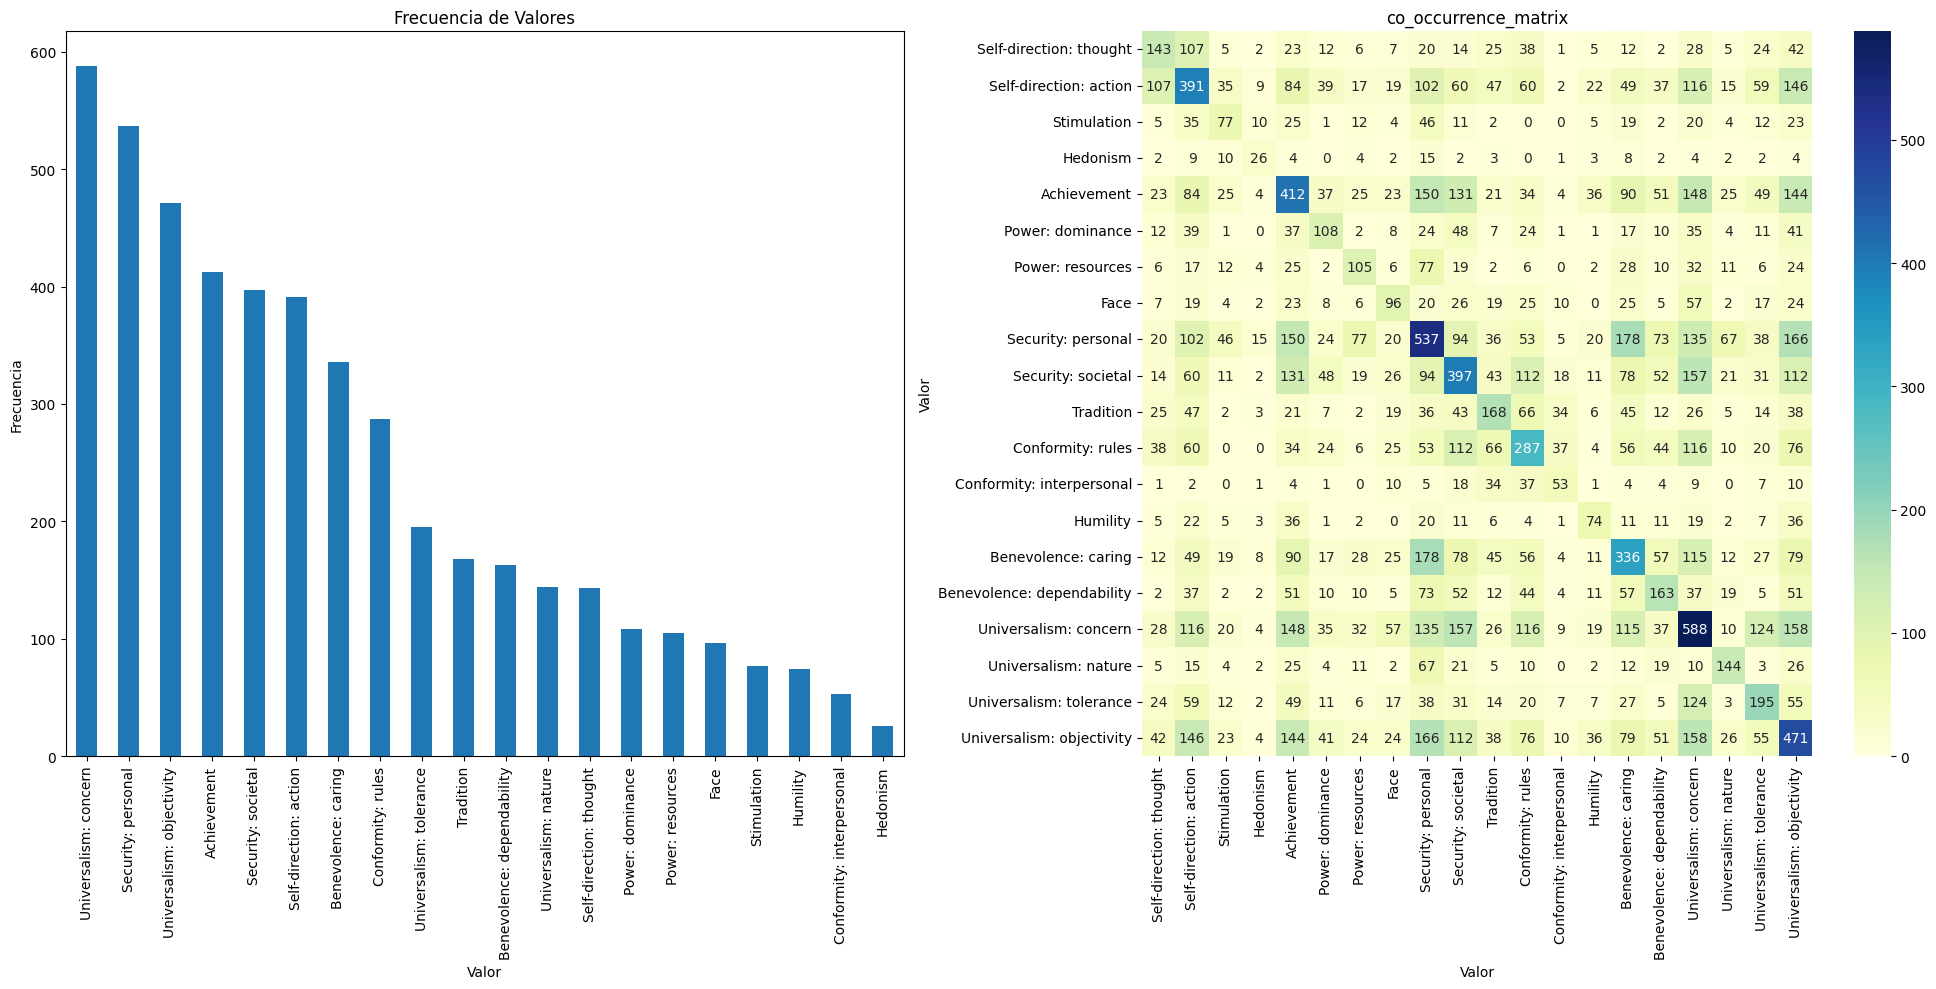

In [11]:
plot_dataset(df_test)

## First Model

In [ ]:
train_dataset = dataset_builder(df_training[0:400])
test_dataset = dataset_builder(df_test[0:80])
validation_dataset = dataset_builder(df_validation[0:60])
optimization_dataset = dataset_builder(df_training[:400])


In [ ]:
# Hiperparámetros
epochs = 2
learning_rate = 5e-5
batchsize = 32

#contruccion del dataloader
train_dataloader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=True)

# Dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configurar el modelo y el optimizador
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20 )
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


# Entrenamiento
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss

        # Backward pass y actualización de parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    # Calcular la pérdida promedio por época
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Average Loss: 0.45766437947750094
Epoch 2/2, Average Loss: 0.3785465906063716


In [ ]:
for batch in train_dataloader:
  print(batch[0])
  break

tensor([[  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  4372,  6494,  ...,     0,     0,     0],
        [  101,  1996, 19076,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 19076,  ...,     0,     0,     0],
        [  101, 15823,  1997,  ...,     0,     0,     0],
        [  101, 11513, 14920,  ...,     0,     0,     0]])


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score



## Optimization of Hyperparameters


model_name = "bert-base-uncased"

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20)

In [ ]:
train_dataset = dataset_builder(df_training[0:400])
test_dataset = dataset_builder(df_test[0:80])
validation_dataset = dataset_builder(df_validation[0:60])
optimization_dataset = dataset_builder(df_training[:400])


In [ ]:


# Dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para la búsqueda de hiperparámetros
def hyperparameter_search(trial, dataset):
    # Configuración del modelo y optimizador

    epochs = 15
    learning_rate = trial.suggest_float('learning_rate', 5e-6, 5e-4)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    # Threshold = trial.suggest_categorical('Threshold', [0.33, 0.5, 0.66])

    print(f'This try consider Learning rate = {learning_rate}, batch_size= {batch_size}.')

    model_name = "bert-base-uncased"
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # # DataLoader (aquí deberías tener tus propios conjuntos de datos)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            del input_ids, attention_masks, labels

        average_loss_train = total_loss / len(train_dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss_train}')

        # del total_loss

    total_loss = 0.0
    # Evaluación usando F1 Score y Recall
    model.eval()
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.sigmoid(logits)

        # y_true.extend(labels.cpu().numpy())
        # y_pred.extend((predictions > Threshold).cpu().numpy())

    average_loss_val = total_loss / len(validation_dataloader)
    print(f'Average Loss: {average_loss_val}')
    # f1 = f1_score(y_true, y_pred, average='micro')
    # recall = recall_score(y_true, y_pred, average='micro')
    # print(f'F1 Score: {f1}')

    return average_loss_val



In [ ]:
torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20)

study = optuna.create_study(direction='minimize')  # Estás minimizando la métrica de la función objetivo
objective_with_data = lambda trial: hyperparameter_search(trial, optimization_dataset)

study.optimize(objective_with_data, n_trials=30)  # Puedes ajustar el número de trials según tus recursos


best_params = study.best_params
print("Best parameters found: ", best_params)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-02-01 23:58:32,212] A new study created in memory with name: no-name-99dbe36a-9994-45ed-959b-2aa51457f910


This try consider Learning rate = 6.276155600362258e-05, batch_size= 16.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5042673742771149
Epoch 2/15, Average Loss: 0.4114315724372864
Epoch 3/15, Average Loss: 0.3990946936607361
Epoch 4/15, Average Loss: 0.38149367451667787
Epoch 5/15, Average Loss: 0.3568958246707916
Epoch 6/15, Average Loss: 0.326715030670166
Epoch 7/15, Average Loss: 0.2984006476402283
Epoch 8/15, Average Loss: 0.27344856441020965
Epoch 9/15, Average Loss: 0.24462496995925903
Epoch 10/15, Average Loss: 0.22546674847602843
Epoch 11/15, Average Loss: 0.2041170394420624
Epoch 12/15, Average Loss: 0.1839316350221634
Epoch 13/15, Average Loss: 0.16567147612571717
Epoch 14/15, Average Loss: 0.15238759636878968
Epoch 15/15, Average Loss: 0.13755416065454484


[I 2024-02-02 00:01:40,758] Trial 0 finished with value: 0.437220923602581 and parameters: {'learning_rate': 6.276155600362258e-05, 'batch_size': 16}. Best is trial 0 with value: 0.437220923602581.


Average Loss: 0.437220923602581
This try consider Learning rate = 0.00046391174819670203, batch_size= 16.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.47230240821838376
Epoch 2/15, Average Loss: 0.4128564977645874
Epoch 3/15, Average Loss: 0.4135183870792389
Epoch 4/15, Average Loss: 0.4145600748062134
Epoch 5/15, Average Loss: 0.41274279832839966
Epoch 6/15, Average Loss: 0.4130769085884094
Epoch 7/15, Average Loss: 0.4145370507240295
Epoch 8/15, Average Loss: 0.41211808800697325
Epoch 9/15, Average Loss: 0.41273969411849976
Epoch 10/15, Average Loss: 0.4127149498462677
Epoch 11/15, Average Loss: 0.41477707505226136
Epoch 12/15, Average Loss: 0.4124529349803925
Epoch 13/15, Average Loss: 0.41237947821617127
Epoch 14/15, Average Loss: 0.4110634088516235
Epoch 15/15, Average Loss: 0.4111020290851593


[I 2024-02-02 00:04:54,659] Trial 1 finished with value: 0.4144897535443306 and parameters: {'learning_rate': 0.00046391174819670203, 'batch_size': 16}. Best is trial 1 with value: 0.4144897535443306.


Average Loss: 0.4144897535443306
This try consider Learning rate = 0.0003307918746480482, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.4881370755342337
Epoch 2/15, Average Loss: 0.4116438329219818
Epoch 3/15, Average Loss: 0.41405953810765195
Epoch 4/15, Average Loss: 0.41363142086909366
Epoch 5/15, Average Loss: 0.4123368240319766
Epoch 6/15, Average Loss: 0.41193209703151995
Epoch 7/15, Average Loss: 0.4140246625129993
Epoch 8/15, Average Loss: 0.4123830497264862
Epoch 9/15, Average Loss: 0.41389723465992856
Epoch 10/15, Average Loss: 0.411657846890963
Epoch 11/15, Average Loss: 0.4099688163170448
Epoch 12/15, Average Loss: 0.4146808019051185
Epoch 13/15, Average Loss: 0.41018170576829177
Epoch 14/15, Average Loss: 0.4136178424725166
Epoch 15/15, Average Loss: 0.4101665180463057


[I 2024-02-02 00:07:59,747] Trial 2 finished with value: 0.410679891705513 and parameters: {'learning_rate': 0.0003307918746480482, 'batch_size': 32}. Best is trial 2 with value: 0.410679891705513.


Average Loss: 0.410679891705513
This try consider Learning rate = 2.805933564999862e-05, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6116429567337036
Epoch 2/15, Average Loss: 0.49186604298078096
Epoch 3/15, Average Loss: 0.44351827181302583
Epoch 4/15, Average Loss: 0.4221401604322287
Epoch 5/15, Average Loss: 0.41270417204269993
Epoch 6/15, Average Loss: 0.40548460070903486
Epoch 7/15, Average Loss: 0.3997195317195012
Epoch 8/15, Average Loss: 0.39190548887619603
Epoch 9/15, Average Loss: 0.3786435585755568
Epoch 10/15, Average Loss: 0.36671621065873367
Epoch 11/15, Average Loss: 0.35559141865143407
Epoch 12/15, Average Loss: 0.34470977462255037
Epoch 13/15, Average Loss: 0.33055537251325756
Epoch 14/15, Average Loss: 0.3178476393222809
Epoch 15/15, Average Loss: 0.3057750486410581


[I 2024-02-02 00:11:04,996] Trial 3 finished with value: 0.39164258539676666 and parameters: {'learning_rate': 2.805933564999862e-05, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.39164258539676666
This try consider Learning rate = 0.00026869756784649897, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5501649166856494
Epoch 2/15, Average Loss: 0.4217445126601628
Epoch 3/15, Average Loss: 0.42921427743775503
Epoch 4/15, Average Loss: 0.4116820991039276
Epoch 5/15, Average Loss: 0.4127327799797058
Epoch 6/15, Average Loss: 0.405502234186445
Epoch 7/15, Average Loss: 0.4058699437550136
Epoch 8/15, Average Loss: 0.41078915766307283
Epoch 9/15, Average Loss: 0.41561746171542574
Epoch 10/15, Average Loss: 0.4056633072240012
Epoch 11/15, Average Loss: 0.4157865217753819
Epoch 12/15, Average Loss: 0.41913536190986633
Epoch 13/15, Average Loss: 0.40921464562416077
Epoch 14/15, Average Loss: 0.4041507627282824
Epoch 15/15, Average Loss: 0.4150415190628597


[I 2024-02-02 00:13:59,604] Trial 4 finished with value: 0.4098324775695801 and parameters: {'learning_rate': 0.00026869756784649897, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4098324775695801
This try consider Learning rate = 0.00024321511782174316, batch_size= 16.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.4541576194763184
Epoch 2/15, Average Loss: 0.4158537578582764
Epoch 3/15, Average Loss: 0.41463830828666687
Epoch 4/15, Average Loss: 0.4143556547164917
Epoch 5/15, Average Loss: 0.4147151017189026
Epoch 6/15, Average Loss: 0.4148175811767578
Epoch 7/15, Average Loss: 0.41324902057647706
Epoch 8/15, Average Loss: 0.4138364839553833
Epoch 9/15, Average Loss: 0.4129922044277191
Epoch 10/15, Average Loss: 0.4121734714508057
Epoch 11/15, Average Loss: 0.4126460421085358
Epoch 12/15, Average Loss: 0.41318065524101255
Epoch 13/15, Average Loss: 0.4129640793800354
Epoch 14/15, Average Loss: 0.4129257798194885
Epoch 15/15, Average Loss: 0.41226828455924985


[I 2024-02-02 00:17:14,228] Trial 5 finished with value: 0.414788194000721 and parameters: {'learning_rate': 0.00024321511782174316, 'batch_size': 16}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.414788194000721
This try consider Learning rate = 0.00041189145489525835, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.49763818298067364
Epoch 2/15, Average Loss: 0.41352008070264545
Epoch 3/15, Average Loss: 0.4155543063368116
Epoch 4/15, Average Loss: 0.41186818906239103
Epoch 5/15, Average Loss: 0.4137666864054544
Epoch 6/15, Average Loss: 0.4110115425927298
Epoch 7/15, Average Loss: 0.416583171912602
Epoch 8/15, Average Loss: 0.41069323675973074
Epoch 9/15, Average Loss: 0.413254086460386
Epoch 10/15, Average Loss: 0.4123912879398891
Epoch 11/15, Average Loss: 0.418570944241115
Epoch 12/15, Average Loss: 0.4137231707572937
Epoch 13/15, Average Loss: 0.4159242468220847
Epoch 14/15, Average Loss: 0.40771385175841196
Epoch 15/15, Average Loss: 0.40989913259233746


[I 2024-02-02 00:20:09,052] Trial 6 finished with value: 0.4133574664592743 and parameters: {'learning_rate': 0.00041189145489525835, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4133574664592743
This try consider Learning rate = 0.0002533694682085933, batch_size= 16.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.45173768162727357
Epoch 2/15, Average Loss: 0.41511275053024294
Epoch 3/15, Average Loss: 0.41489267110824585
Epoch 4/15, Average Loss: 0.4137038469314575
Epoch 5/15, Average Loss: 0.41196460008621216
Epoch 6/15, Average Loss: 0.4133894968032837
Epoch 7/15, Average Loss: 0.41255496501922606
Epoch 8/15, Average Loss: 0.41237853169441224
Epoch 9/15, Average Loss: 0.4132622575759888
Epoch 10/15, Average Loss: 0.41426709294319153
Epoch 11/15, Average Loss: 0.4119014132022858
Epoch 12/15, Average Loss: 0.41420410871505736
Epoch 13/15, Average Loss: 0.4143275678157806
Epoch 14/15, Average Loss: 0.41455389857292174
Epoch 15/15, Average Loss: 0.4124226725101471


[I 2024-02-02 00:23:23,220] Trial 7 finished with value: 0.4103770777583122 and parameters: {'learning_rate': 0.0002533694682085933, 'batch_size': 16}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4103770777583122
This try consider Learning rate = 0.0002650866935173455, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.48669318052438587
Epoch 2/15, Average Loss: 0.41269312225855315
Epoch 3/15, Average Loss: 0.41272796805088335
Epoch 4/15, Average Loss: 0.4150223915393536
Epoch 5/15, Average Loss: 0.4129544221437894
Epoch 6/15, Average Loss: 0.41166348182238066
Epoch 7/15, Average Loss: 0.41215882851527286
Epoch 8/15, Average Loss: 0.41075677825854373
Epoch 9/15, Average Loss: 0.41366629417125994
Epoch 10/15, Average Loss: 0.4124669524339529
Epoch 11/15, Average Loss: 0.41318814341838545
Epoch 12/15, Average Loss: 0.4116865534048814
Epoch 13/15, Average Loss: 0.4109673522985898
Epoch 14/15, Average Loss: 0.4121891512320592
Epoch 15/15, Average Loss: 0.41266769629258376


[I 2024-02-02 00:26:27,654] Trial 8 finished with value: 0.4102790206670761 and parameters: {'learning_rate': 0.0002650866935173455, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4102790206670761
This try consider Learning rate = 7.30001295461629e-06, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.7095425980431693
Epoch 2/15, Average Loss: 0.6782763940947396
Epoch 3/15, Average Loss: 0.6390503389494759
Epoch 4/15, Average Loss: 0.5959037372044155
Epoch 5/15, Average Loss: 0.5562905584062848
Epoch 6/15, Average Loss: 0.5278214045933315
Epoch 7/15, Average Loss: 0.5051986404827663
Epoch 8/15, Average Loss: 0.49061972754342215
Epoch 9/15, Average Loss: 0.48290498341832844
Epoch 10/15, Average Loss: 0.4696009159088135
Epoch 11/15, Average Loss: 0.4625933808939798
Epoch 12/15, Average Loss: 0.4577218507017408
Epoch 13/15, Average Loss: 0.4488120036465781
Epoch 14/15, Average Loss: 0.44083338550158907
Epoch 15/15, Average Loss: 0.43904381138937815


[I 2024-02-02 00:29:23,370] Trial 9 finished with value: 0.4397090673446655 and parameters: {'learning_rate': 7.30001295461629e-06, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4397090673446655
This try consider Learning rate = 0.00012729305965804654, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5312429230946761
Epoch 2/15, Average Loss: 0.41226521363625157
Epoch 3/15, Average Loss: 0.4066136387678293
Epoch 4/15, Average Loss: 0.39250537294607896
Epoch 5/15, Average Loss: 0.3696495913542234
Epoch 6/15, Average Loss: 0.3415628190223987
Epoch 7/15, Average Loss: 0.30494882739507234
Epoch 8/15, Average Loss: 0.2722501433812655
Epoch 9/15, Average Loss: 0.2449415268806311
Epoch 10/15, Average Loss: 0.2162918563072498
Epoch 11/15, Average Loss: 0.19525093069443336
Epoch 12/15, Average Loss: 0.17099752792945275
Epoch 13/15, Average Loss: 0.15067641952863106
Epoch 14/15, Average Loss: 0.13076752080367163
Epoch 15/15, Average Loss: 0.11552753127538241


[I 2024-02-02 00:32:29,182] Trial 10 finished with value: 0.4510966092348099 and parameters: {'learning_rate': 0.00012729305965804654, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4510966092348099
This try consider Learning rate = 0.0001708668256413986, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6163412289960044
Epoch 2/15, Average Loss: 0.44105081473078045
Epoch 3/15, Average Loss: 0.4234856196812221
Epoch 4/15, Average Loss: 0.40666293672152926
Epoch 5/15, Average Loss: 0.4125486399446215
Epoch 6/15, Average Loss: 0.4123226148741586
Epoch 7/15, Average Loss: 0.40798849293163847
Epoch 8/15, Average Loss: 0.4078455482210432
Epoch 9/15, Average Loss: 0.40549480063574656
Epoch 10/15, Average Loss: 0.407024873154504
Epoch 11/15, Average Loss: 0.40086229358400616
Epoch 12/15, Average Loss: 0.3949835939066751
Epoch 13/15, Average Loss: 0.37181636691093445
Epoch 14/15, Average Loss: 0.3686449187142508
Epoch 15/15, Average Loss: 0.35101538470813204


[I 2024-02-02 00:35:24,528] Trial 11 finished with value: 0.40117147564888 and parameters: {'learning_rate': 0.0001708668256413986, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.40117147564888
This try consider Learning rate = 0.000124398083516356, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6344750438417707
Epoch 2/15, Average Loss: 0.47393096344811575
Epoch 3/15, Average Loss: 0.4199003151484898
Epoch 4/15, Average Loss: 0.4045726018292563
Epoch 5/15, Average Loss: 0.41091734170913696
Epoch 6/15, Average Loss: 0.4092863031796047
Epoch 7/15, Average Loss: 0.40919786265918184
Epoch 8/15, Average Loss: 0.39589036788259235
Epoch 9/15, Average Loss: 0.382596812077931
Epoch 10/15, Average Loss: 0.3638186880520412
Epoch 11/15, Average Loss: 0.34099783641951426
Epoch 12/15, Average Loss: 0.3281548534120832
Epoch 13/15, Average Loss: 0.3036888028894152
Epoch 14/15, Average Loss: 0.2833012342453003
Epoch 15/15, Average Loss: 0.2621325658900397


[I 2024-02-02 00:38:19,586] Trial 12 finished with value: 0.4141150116920471 and parameters: {'learning_rate': 0.000124398083516356, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4141150116920471
This try consider Learning rate = 0.00015224600106351509, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5437968396223508
Epoch 2/15, Average Loss: 0.41330548433157116
Epoch 3/15, Average Loss: 0.4125087536298312
Epoch 4/15, Average Loss: 0.40964511724618763
Epoch 5/15, Average Loss: 0.4112574549821707
Epoch 6/15, Average Loss: 0.40803642914845395
Epoch 7/15, Average Loss: 0.399462307874973
Epoch 8/15, Average Loss: 0.38932430285673875
Epoch 9/15, Average Loss: 0.38484248977441055
Epoch 10/15, Average Loss: 0.3724223283620981
Epoch 11/15, Average Loss: 0.3594611814388862
Epoch 12/15, Average Loss: 0.3430143663516411
Epoch 13/15, Average Loss: 0.3293681970009437
Epoch 14/15, Average Loss: 0.3098745048046112
Epoch 15/15, Average Loss: 0.2927151597463168


[I 2024-02-02 00:41:24,664] Trial 13 finished with value: 0.4029088318347931 and parameters: {'learning_rate': 0.00015224600106351509, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4029088318347931
This try consider Learning rate = 2.9256940382042566e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6299104520252773
Epoch 2/15, Average Loss: 0.5395941734313965
Epoch 3/15, Average Loss: 0.48456833192280363
Epoch 4/15, Average Loss: 0.4521458702428
Epoch 5/15, Average Loss: 0.4294532196862357
Epoch 6/15, Average Loss: 0.42195670093808857
Epoch 7/15, Average Loss: 0.41919463872909546
Epoch 8/15, Average Loss: 0.4109973737171718
Epoch 9/15, Average Loss: 0.40184566378593445
Epoch 10/15, Average Loss: 0.39765745401382446
Epoch 11/15, Average Loss: 0.38838515111378263
Epoch 12/15, Average Loss: 0.38232051048960003
Epoch 13/15, Average Loss: 0.37907794543675016
Epoch 14/15, Average Loss: 0.3701622997011457
Epoch 15/15, Average Loss: 0.35171084318842205


[I 2024-02-02 00:44:20,169] Trial 14 finished with value: 0.3979337513446808 and parameters: {'learning_rate': 2.9256940382042566e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.3979337513446808
This try consider Learning rate = 5.614681461659211e-06, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6551609956301175
Epoch 2/15, Average Loss: 0.609760765845959
Epoch 3/15, Average Loss: 0.573624285367819
Epoch 4/15, Average Loss: 0.5432561727670523
Epoch 5/15, Average Loss: 0.5174864920286032
Epoch 6/15, Average Loss: 0.4979394467977377
Epoch 7/15, Average Loss: 0.48490867247948277
Epoch 8/15, Average Loss: 0.47300957028682417
Epoch 9/15, Average Loss: 0.46229238235033476
Epoch 10/15, Average Loss: 0.45304080614676845
Epoch 11/15, Average Loss: 0.4458148433611943
Epoch 12/15, Average Loss: 0.4392445912727943
Epoch 13/15, Average Loss: 0.4330315383581015
Epoch 14/15, Average Loss: 0.42942813497323257
Epoch 15/15, Average Loss: 0.428779083948869


[I 2024-02-02 00:47:24,974] Trial 15 finished with value: 0.43001890182495117 and parameters: {'learning_rate': 5.614681461659211e-06, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.43001890182495117
This try consider Learning rate = 8.1190134086054e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5998034306934902
Epoch 2/15, Average Loss: 0.46694938625608173
Epoch 3/15, Average Loss: 0.4215638041496277
Epoch 4/15, Average Loss: 0.4097511555467333
Epoch 5/15, Average Loss: 0.40170663595199585
Epoch 6/15, Average Loss: 0.39328581946236746
Epoch 7/15, Average Loss: 0.3849025751863207
Epoch 8/15, Average Loss: 0.36747486676488605
Epoch 9/15, Average Loss: 0.3540300045694624
Epoch 10/15, Average Loss: 0.33633423277309965
Epoch 11/15, Average Loss: 0.31704392177718027
Epoch 12/15, Average Loss: 0.2952476463147572
Epoch 13/15, Average Loss: 0.2841506940977914
Epoch 14/15, Average Loss: 0.26135543627398355
Epoch 15/15, Average Loss: 0.2501921717609678


[I 2024-02-02 00:50:20,387] Trial 16 finished with value: 0.40384915471076965 and parameters: {'learning_rate': 8.1190134086054e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.40384915471076965
This try consider Learning rate = 6.014607700906989e-05, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6135781728304349
Epoch 2/15, Average Loss: 0.4559166500201592
Epoch 3/15, Average Loss: 0.41720852714318496
Epoch 4/15, Average Loss: 0.40662917036276597
Epoch 5/15, Average Loss: 0.4024186157263242
Epoch 6/15, Average Loss: 0.38926571149092454
Epoch 7/15, Average Loss: 0.3704140300934131
Epoch 8/15, Average Loss: 0.3498329955797929
Epoch 9/15, Average Loss: 0.32396251880205595
Epoch 10/15, Average Loss: 0.3047261352722461
Epoch 11/15, Average Loss: 0.28629289452846235
Epoch 12/15, Average Loss: 0.2675655289338185
Epoch 13/15, Average Loss: 0.24908440846663255
Epoch 14/15, Average Loss: 0.23168719273347121
Epoch 15/15, Average Loss: 0.21538257140379685


[I 2024-02-02 00:53:26,607] Trial 17 finished with value: 0.40696077048778534 and parameters: {'learning_rate': 6.014607700906989e-05, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.40696077048778534
This try consider Learning rate = 0.00021070680349233317, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5419820078781673
Epoch 2/15, Average Loss: 0.41574577348572866
Epoch 3/15, Average Loss: 0.41205846411841257
Epoch 4/15, Average Loss: 0.4098455991063799
Epoch 5/15, Average Loss: 0.40672444445746286
Epoch 6/15, Average Loss: 0.4195702927453177
Epoch 7/15, Average Loss: 0.4032613549913679
Epoch 8/15, Average Loss: 0.3974614143371582
Epoch 9/15, Average Loss: 0.39206365176609587
Epoch 10/15, Average Loss: 0.3855560762541635
Epoch 11/15, Average Loss: 0.3643489480018616
Epoch 12/15, Average Loss: 0.34926457915987286
Epoch 13/15, Average Loss: 0.3344210386276245
Epoch 14/15, Average Loss: 0.31508838278906687
Epoch 15/15, Average Loss: 0.301533831017358


[I 2024-02-02 00:56:21,859] Trial 18 finished with value: 0.4015533924102783 and parameters: {'learning_rate': 0.00021070680349233317, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4015533924102783
This try consider Learning rate = 0.0003558141887311056, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.47635719638604385
Epoch 2/15, Average Loss: 0.41583648782510024
Epoch 3/15, Average Loss: 0.41343721518149745
Epoch 4/15, Average Loss: 0.4108779590863448
Epoch 5/15, Average Loss: 0.412286829489928
Epoch 6/15, Average Loss: 0.41474799467967105
Epoch 7/15, Average Loss: 0.41467804404405445
Epoch 8/15, Average Loss: 0.41174623370170593
Epoch 9/15, Average Loss: 0.41251508318460905
Epoch 10/15, Average Loss: 0.41299568919035107
Epoch 11/15, Average Loss: 0.41147448695622957
Epoch 12/15, Average Loss: 0.41237937487088716
Epoch 13/15, Average Loss: 0.4150393994954916
Epoch 14/15, Average Loss: 0.4139694571495056
Epoch 15/15, Average Loss: 0.41111581371380734


[I 2024-02-02 00:59:26,588] Trial 19 finished with value: 0.4135268032550812 and parameters: {'learning_rate': 0.0003558141887311056, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4135268032550812
This try consider Learning rate = 8.524881398631903e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6290731515203204
Epoch 2/15, Average Loss: 0.4790501296520233
Epoch 3/15, Average Loss: 0.4248537761824472
Epoch 4/15, Average Loss: 0.41060339978763033
Epoch 5/15, Average Loss: 0.40485664350645884
Epoch 6/15, Average Loss: 0.40085231406348093
Epoch 7/15, Average Loss: 0.39413052797317505
Epoch 8/15, Average Loss: 0.3882964721747807
Epoch 9/15, Average Loss: 0.3807040921279362
Epoch 10/15, Average Loss: 0.36011398264339994
Epoch 11/15, Average Loss: 0.3474607467651367
Epoch 12/15, Average Loss: 0.3274900146893093
Epoch 13/15, Average Loss: 0.31258718030793325
Epoch 14/15, Average Loss: 0.29301964810916353
Epoch 15/15, Average Loss: 0.2737842925957271


[I 2024-02-02 01:02:22,178] Trial 20 finished with value: 0.3918529748916626 and parameters: {'learning_rate': 8.524881398631903e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.3918529748916626
This try consider Learning rate = 8.382146386700864e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6436905435153416
Epoch 2/15, Average Loss: 0.4885234236717224
Epoch 3/15, Average Loss: 0.43821644357272554
Epoch 4/15, Average Loss: 0.40619868465832304
Epoch 5/15, Average Loss: 0.40452970777239117
Epoch 6/15, Average Loss: 0.40110549330711365
Epoch 7/15, Average Loss: 0.4060674692903246
Epoch 8/15, Average Loss: 0.3970970852034433
Epoch 9/15, Average Loss: 0.3888156797204699
Epoch 10/15, Average Loss: 0.3789649520601545
Epoch 11/15, Average Loss: 0.3598989801747458
Epoch 12/15, Average Loss: 0.3425758310726711
Epoch 13/15, Average Loss: 0.33084701214517864
Epoch 14/15, Average Loss: 0.31065642833709717
Epoch 15/15, Average Loss: 0.29076591559818815


[I 2024-02-02 01:05:17,524] Trial 21 finished with value: 0.3942907452583313 and parameters: {'learning_rate': 8.382146386700864e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.3942907452583313
This try consider Learning rate = 0.00010126761573848872, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6426595279148647
Epoch 2/15, Average Loss: 0.48237631576401846
Epoch 3/15, Average Loss: 0.4181721423353468
Epoch 4/15, Average Loss: 0.4070623346737453
Epoch 5/15, Average Loss: 0.4151638533387865
Epoch 6/15, Average Loss: 0.4076969453266689
Epoch 7/15, Average Loss: 0.41537751044545856
Epoch 8/15, Average Loss: 0.4036237214292799
Epoch 9/15, Average Loss: 0.4002637820584433
Epoch 10/15, Average Loss: 0.3914050417287009
Epoch 11/15, Average Loss: 0.3838308964456831
Epoch 12/15, Average Loss: 0.36578449606895447
Epoch 13/15, Average Loss: 0.35134002566337585
Epoch 14/15, Average Loss: 0.3412518245833261
Epoch 15/15, Average Loss: 0.3198452464171818


[I 2024-02-02 01:08:12,562] Trial 22 finished with value: 0.39811697602272034 and parameters: {'learning_rate': 0.00010126761573848872, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.39811697602272034
This try consider Learning rate = 0.00018129015796488886, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5853413939476013
Epoch 2/15, Average Loss: 0.42364988582474844
Epoch 3/15, Average Loss: 0.41826505746160236
Epoch 4/15, Average Loss: 0.4090885009084429
Epoch 5/15, Average Loss: 0.4026926415307181
Epoch 6/15, Average Loss: 0.4099696491445814
Epoch 7/15, Average Loss: 0.40898495486804415
Epoch 8/15, Average Loss: 0.40783182638032095
Epoch 9/15, Average Loss: 0.4067734735352652
Epoch 10/15, Average Loss: 0.4161949796336038
Epoch 11/15, Average Loss: 0.4075550947870527
Epoch 12/15, Average Loss: 0.40029750977243694
Epoch 13/15, Average Loss: 0.403535144669669
Epoch 14/15, Average Loss: 0.39699818406786236
Epoch 15/15, Average Loss: 0.39421978167125155


[I 2024-02-02 01:11:07,723] Trial 23 finished with value: 0.42559871077537537 and parameters: {'learning_rate': 0.00018129015796488886, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.42559871077537537
This try consider Learning rate = 5.3202172554890735e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6197302256311689
Epoch 2/15, Average Loss: 0.5088102221488953
Epoch 3/15, Average Loss: 0.4495302736759186
Epoch 4/15, Average Loss: 0.4226762907845633
Epoch 5/15, Average Loss: 0.4101510090487344
Epoch 6/15, Average Loss: 0.40679988265037537
Epoch 7/15, Average Loss: 0.4030060853276934
Epoch 8/15, Average Loss: 0.396891108580998
Epoch 9/15, Average Loss: 0.38608141030584064
Epoch 10/15, Average Loss: 0.3762957751750946
Epoch 11/15, Average Loss: 0.36348181537219454
Epoch 12/15, Average Loss: 0.35261895401137217
Epoch 13/15, Average Loss: 0.3390615539891379
Epoch 14/15, Average Loss: 0.324247990335737
Epoch 15/15, Average Loss: 0.3143637180328369


[I 2024-02-02 01:14:03,216] Trial 24 finished with value: 0.392035573720932 and parameters: {'learning_rate': 5.3202172554890735e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.392035573720932
This try consider Learning rate = 4.785550935531025e-05, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5876576258586004
Epoch 2/15, Average Loss: 0.46111141259853655
Epoch 3/15, Average Loss: 0.4197090222285344
Epoch 4/15, Average Loss: 0.40445476770401
Epoch 5/15, Average Loss: 0.3928350003866049
Epoch 6/15, Average Loss: 0.3835362173043765
Epoch 7/15, Average Loss: 0.3706979934985821
Epoch 8/15, Average Loss: 0.3559202505992009
Epoch 9/15, Average Loss: 0.3397902479538551
Epoch 10/15, Average Loss: 0.32453964994503903
Epoch 11/15, Average Loss: 0.30695987893984866
Epoch 12/15, Average Loss: 0.2907902965178856
Epoch 13/15, Average Loss: 0.27537834644317627
Epoch 14/15, Average Loss: 0.25794478677786314
Epoch 15/15, Average Loss: 0.24484016230473152


[I 2024-02-02 01:17:08,778] Trial 25 finished with value: 0.4057692438364029 and parameters: {'learning_rate': 4.785550935531025e-05, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4057692438364029
This try consider Learning rate = 0.00011493137697239899, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5636173869882312
Epoch 2/15, Average Loss: 0.4411488558564867
Epoch 3/15, Average Loss: 0.4127549571650369
Epoch 4/15, Average Loss: 0.4202547243663243
Epoch 5/15, Average Loss: 0.4064607620239258
Epoch 6/15, Average Loss: 0.3964405187538692
Epoch 7/15, Average Loss: 0.38228268708501545
Epoch 8/15, Average Loss: 0.3619618628706251
Epoch 9/15, Average Loss: 0.34428409593445913
Epoch 10/15, Average Loss: 0.32330254146030973
Epoch 11/15, Average Loss: 0.30407245244298664
Epoch 12/15, Average Loss: 0.2847426618848528
Epoch 13/15, Average Loss: 0.2636543703930719
Epoch 14/15, Average Loss: 0.242976969906262
Epoch 15/15, Average Loss: 0.22605974120753153


[I 2024-02-02 01:20:04,223] Trial 26 finished with value: 0.39953601360321045 and parameters: {'learning_rate': 0.00011493137697239899, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.39953601360321045
This try consider Learning rate = 3.6619357295010035e-05, batch_size= 64.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.6602826629366193
Epoch 2/15, Average Loss: 0.558831478868212
Epoch 3/15, Average Loss: 0.4901534191199711
Epoch 4/15, Average Loss: 0.45111688545772005
Epoch 5/15, Average Loss: 0.42669134054865154
Epoch 6/15, Average Loss: 0.4155228393418448
Epoch 7/15, Average Loss: 0.4078106241566794
Epoch 8/15, Average Loss: 0.4051424562931061
Epoch 9/15, Average Loss: 0.3998013734817505
Epoch 10/15, Average Loss: 0.39397148149354116
Epoch 11/15, Average Loss: 0.39055605445589336
Epoch 12/15, Average Loss: 0.39244269898959566
Epoch 13/15, Average Loss: 0.3815273940563202
Epoch 14/15, Average Loss: 0.3707617734159742
Epoch 15/15, Average Loss: 0.36815427456583294


[I 2024-02-02 01:22:59,658] Trial 27 finished with value: 0.398645281791687 and parameters: {'learning_rate': 3.6619357295010035e-05, 'batch_size': 64}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.398645281791687
This try consider Learning rate = 0.00014356434334354315, batch_size= 16.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.46341322660446166
Epoch 2/15, Average Loss: 0.4032737731933594
Epoch 3/15, Average Loss: 0.37520945906639097
Epoch 4/15, Average Loss: 0.3432337605953217
Epoch 5/15, Average Loss: 0.30618532180786134
Epoch 6/15, Average Loss: 0.27324259459972383
Epoch 7/15, Average Loss: 0.24856876492500304
Epoch 8/15, Average Loss: 0.2168990045785904
Epoch 9/15, Average Loss: 0.19013921082019805
Epoch 10/15, Average Loss: 0.1706063124537468
Epoch 11/15, Average Loss: 0.1471104896068573
Epoch 12/15, Average Loss: 0.1293907108902931
Epoch 13/15, Average Loss: 0.10903549879789352
Epoch 14/15, Average Loss: 0.0954602900147438
Epoch 15/15, Average Loss: 0.08488498598337174


[I 2024-02-02 01:26:14,594] Trial 28 finished with value: 0.503971204161644 and parameters: {'learning_rate': 0.00014356434334354315, 'batch_size': 16}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.503971204161644
This try consider Learning rate = 7.336537369752975e-05, batch_size= 32.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Average Loss: 0.5284488843037531
Epoch 2/15, Average Loss: 0.4189020280654614
Epoch 3/15, Average Loss: 0.4074997558043553
Epoch 4/15, Average Loss: 0.39968114174329317
Epoch 5/15, Average Loss: 0.3823559398834522
Epoch 6/15, Average Loss: 0.3618486844576322
Epoch 7/15, Average Loss: 0.34036434155244094
Epoch 8/15, Average Loss: 0.3152621892782358
Epoch 9/15, Average Loss: 0.291967320900697
Epoch 10/15, Average Loss: 0.26634633311858547
Epoch 11/15, Average Loss: 0.24219269592028397
Epoch 12/15, Average Loss: 0.22147364685168633
Epoch 13/15, Average Loss: 0.20422496360081893
Epoch 14/15, Average Loss: 0.19040150252672342
Epoch 15/15, Average Loss: 0.17748049589303824


[I 2024-02-02 01:29:19,892] Trial 29 finished with value: 0.4153848737478256 and parameters: {'learning_rate': 7.336537369752975e-05, 'batch_size': 32}. Best is trial 3 with value: 0.39164258539676666.


Average Loss: 0.4153848737478256
Best parameters found:  {'learning_rate': 2.805933564999862e-05, 'batch_size': 32}


Best parameters found:  {'epochs': 8, 'learning_rate': 0.00015080099528917156, 'batch_size': 32}  Loss: 0.42151385843753814
Best parameters found:  {'learning_rate': 0.002297894417530482, 'batch_size': 16, 'Threshold': 0.66} Loss: 0.4151332215601657

Best parameters found:  {'learning_rate': 2.805933564999862e-05, 'batch_size': 32}




## Training Model with the best Hyperparameters

In [34]:
train_dataset = dataset_builder(df_training)
test_dataset = dataset_builder(df_test)
validation_dataset = dataset_builder(df_validation)

<class 'pandas.core.frame.DataFrame'>
(5393, 20)
<class 'pandas.core.frame.DataFrame'>
(1576, 20)
<class 'pandas.core.frame.DataFrame'>
(1896, 20)


In [35]:
# Dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 20
learning_rate = 2.805933564999862e-05
batch_size = 32
Threshold = 0.66

hist_loss_train = []
hist_loss_test = []
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# # DataLoader (aquí deberías tener tus propios conjuntos de datos)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# Entrenamiento
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss_train = total_loss / len(train_dataloader)
    hist_loss_train.append(average_loss_train)

    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {average_loss_train}')

    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0.0

    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.sigmoid(logits)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend((predictions > Threshold).cpu().numpy())

    average_loss_val = total_loss / len(test_dataloader)
    hist_loss_test.append(average_loss_val)

    print(f'Average Test Loss: {average_loss_val}')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    print(f'F1 Score Micro: {f1_micro} and F1 Score Macro: {f1_macro}')

    if hist_loss_test and average_loss_val<=min(hist_loss_test) :
        model_path = "/content/drive/MyDrive/Colab Notebooks/INFORET/InfoRet_model.pth"  # Reemplaza con la ruta deseada en tu Google Drive
        torch.save(model.state_dict(), model_path)
        print(f'The best epoch is {epoch} with Loss: {average_loss_val}')

# Guardar el modelo en Google Drive
model_path = "/content/drive/MyDrive/Colab Notebooks/INFORET/InfoRet_model_last.pth"  # Reemplaza con la ruta deseada en tu Google Drive
torch.save(model.state_dict(), model_path)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20, Average Training Loss: 0.4257457693652994
Average Test Loss: 0.3511984246969223
F1 Score Micro: 0.05805927730410069 and F1 Score Macro: 0.022110441185198636
The best epoch is 0 with Loss: 0.3511984246969223
Epoch 2/20, Average Training Loss: 0.346800940276603
Average Test Loss: 0.3215098923444748
F1 Score Micro: 0.30884865049538773 and F1 Score Macro: 0.14488443626554978
The best epoch is 1 with Loss: 0.3215098923444748
Epoch 3/20, Average Training Loss: 0.30578937403549106
Average Test Loss: 0.30917063176631926
F1 Score Micro: 0.3747765317731188 and F1 Score Macro: 0.22089483639026283
The best epoch is 2 with Loss: 0.30917063176631926
Epoch 4/20, Average Training Loss: 0.27139427640734337
Average Test Loss: 0.3070548778772354
F1 Score Micro: 0.422590957527782 and F1 Score Macro: 0.269857528160531
The best epoch is 3 with Loss: 0.3070548778772354
Epoch 5/20, Average Training Loss: 0.24038192180134135
Average Test Loss: 0.3112789511680603
F1 Score Micro: 0.4586226851851851 a

In [36]:
# Guardar el modelo en Google Drive
model_path = "/content/drive/MyDrive/Colab Notebooks/INFORET/InfoRet_model_last.pth"  # Reemplaza con la ruta deseada en tu Google Drive
torch.save(model.state_dict(), model_path)

## Load the best model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "bert-base-uncased"  # Reemplaza con el nombre correcto de tu modelo

# Crear una instancia del modelo
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=20)
model.to(device)

# Cargar los pesos guardados del modelo
model_path = "/content/drive/MyDrive/Colab Notebooks/INFORET/InfoRet_model_1.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## Evaluation of the model


In [13]:
train_dataset = dataset_builder(df_training)
test_dataset = dataset_builder(df_test)
validation_dataset = dataset_builder(df_validation)
value_columns = df_test.columns[4:]



<class 'pandas.core.frame.DataFrame'>
(5393, 20)
<class 'pandas.core.frame.DataFrame'>
(1576, 20)
<class 'pandas.core.frame.DataFrame'>
(1896, 20)


In [14]:
#
epochs = 8
learning_rate = 0.00015080099528917156
batch_size = 32


def evaluation(model, dataset, epochs, learning_rate, batch_size):

    model.eval()

    total_loss = 0.0
    y_true = []
    y_pred = []

    test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.sigmoid(logits)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    average_loss_val = total_loss / len(dataset)
    y_true1 = np.array(y_true)
    y_pred1 = np.array(y_pred)

    return average_loss_val, y_true1, y_pred1

def best_threshold(y_true, y_pred_prob):
    Micro_f1 = []
    Macro_f1 = []
    for i in range(1,101):
        threshold = i/100
        y_pred = y_pred_prob > threshold
        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        Micro_f1.append(f1_micro)
        Macro_f1.append(f1_macro)
        if f1_micro >= max(Micro_f1):
            best_threshold = threshold
            # print(f'F1 Score Micro: {f1_micro} and F1 Score Macro: {f1_macro} for the Threshold: {threshold}')
        print(f'F1 Score Micro: {f1_micro} and F1 Score Macro: {f1_macro} for the Threshold: {threshold}')

    return best_threshold, Micro_f1, Macro_f1

In [15]:
# Check in the validation dataset wich is the best threshold using the F1 score as a metric
loss, y_true, y_pred_prob = evaluation(model, validation_dataset, epochs, learning_rate, batch_size)
#Get the best threshold for the validation dataset
Threshold, Micro, Macro = best_threshold(y_true, y_pred_prob)

F1 Score Micro: 0.29612457557663036 and F1 Score Macro: 0.275604400951129 for the Threshold: 0.01
F1 Score Micro: 0.3222682547902641 and F1 Score Macro: 0.2920087780323697 for the Threshold: 0.02
F1 Score Micro: 0.3490706746213859 and F1 Score Macro: 0.3118872525181644 for the Threshold: 0.03
F1 Score Micro: 0.37504328391097674 and F1 Score Macro: 0.3320042296992128 for the Threshold: 0.04
F1 Score Micro: 0.3971370143149284 and F1 Score Macro: 0.350648651334237 for the Threshold: 0.05
F1 Score Micro: 0.41645694277273226 and F1 Score Macro: 0.36550863639425907 for the Threshold: 0.06
F1 Score Micro: 0.43322336503007947 and F1 Score Macro: 0.3783135569505249 for the Threshold: 0.07
F1 Score Micro: 0.44692140007403436 and F1 Score Macro: 0.3869522140748754 for the Threshold: 0.08
F1 Score Micro: 0.4584614052556388 and F1 Score Macro: 0.3923513962367948 for the Threshold: 0.09
F1 Score Micro: 0.4705293796616336 and F1 Score Macro: 0.40110602438285897 for the Threshold: 0.1
F1 Score Micro: 

In [41]:
print(f'The Best Threshold for the validation dataset is: {Threshold} \n Where the F1-Score Gotten for this Threshold is: {max(Micro)}')

The Best Threshold for the validation dataset is: 0.16 
 Where the F1-Score Gotten for this Threshold is: 0.5427052923122988


### F1_Score


In [19]:
Threshold


0.3

In [16]:
# execute the evaluation on the test_dataset
loss, y_true, y_pred_prob = evaluation(model, test_dataset, epochs, learning_rate, batch_size)
# get the best threshold for the test set. this just for curiosity because this value won't be used
best_threshold_test, Micro, Macro = best_threshold(y_true, y_pred_prob)

print(f'The Best Threshold for the Test dataset is: {Threshold} \n Where the F1-Score Gotten for this Threshold is: {max(Micro)}')

F1 Score Micro: 0.27200548352087733 and F1 Score Macro: 0.2526222219358997 for the Threshold: 0.01
F1 Score Micro: 0.29598189020939447 and F1 Score Macro: 0.2683225579439248 for the Threshold: 0.02
F1 Score Micro: 0.32307155322862124 and F1 Score Macro: 0.28786013411823885 for the Threshold: 0.03
F1 Score Micro: 0.35072665429808286 and F1 Score Macro: 0.30960160199389153 for the Threshold: 0.04
F1 Score Micro: 0.3752748181971926 and F1 Score Macro: 0.3285004636170567 for the Threshold: 0.05
F1 Score Micro: 0.397726230860915 and F1 Score Macro: 0.34723900532427565 for the Threshold: 0.06
F1 Score Micro: 0.4168181148386463 and F1 Score Macro: 0.3643588137492062 for the Threshold: 0.07
F1 Score Micro: 0.4314176645923757 and F1 Score Macro: 0.3757060651735723 for the Threshold: 0.08
F1 Score Micro: 0.4447400509921295 and F1 Score Macro: 0.38458422910529255 for the Threshold: 0.09
F1 Score Micro: 0.456552207428171 and F1 Score Macro: 0.39231359870919824 for the Threshold: 0.1
F1 Score Micro

However, the F1-Score getting with the best Threshold of the validation set (0,3) is = 0.5515, so this value will be which I will use with the comparison wiht the results of other models participating in the challenges of TaskEval 4.

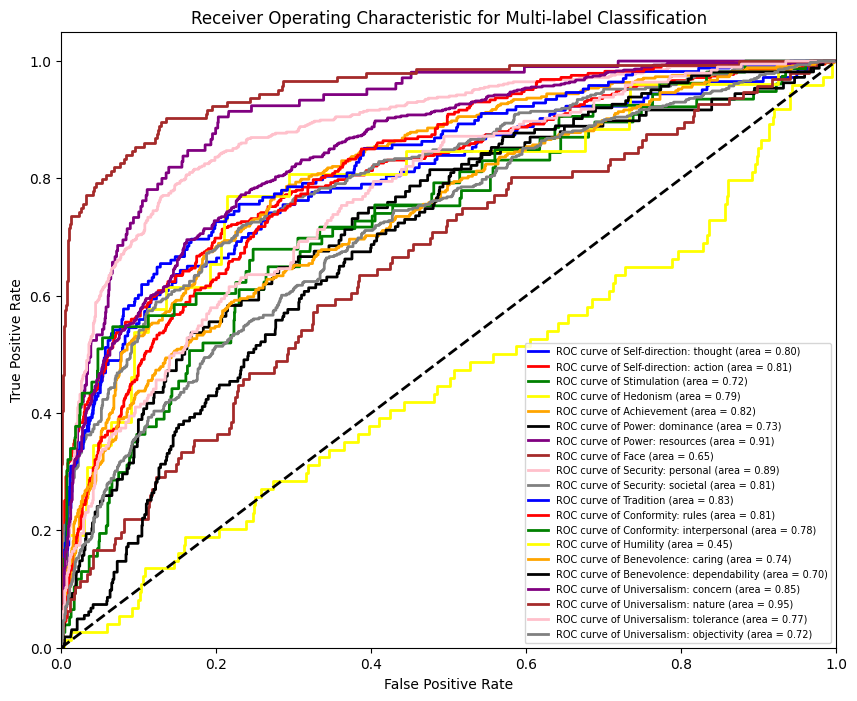

In [17]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# I use the threshold of the validation dataset because in the real world I don't have way to get the best threshold for the test set

# Calcular la curva ROC para cada etiqueta
n_labels = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
f1 = dict()
y_pred = y_pred_prob > Threshold


for i in range(n_labels):
    fpr[i], tpr[i], threshold = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    f1[value_columns[i]] = f1_score(y_true[:, i], y_pred[:, i])


plt.figure(figsize=(10, 8))

# Graficar la curva ROC para cada etiqueta
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'black', 'purple', 'brown', 'pink', 'gray'])
for i, color in zip(range(n_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {00} (area = {1:0.2f})'.format(value_columns[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-label Classification')
plt.legend(loc="lower right", fontsize=7)
plt.show()

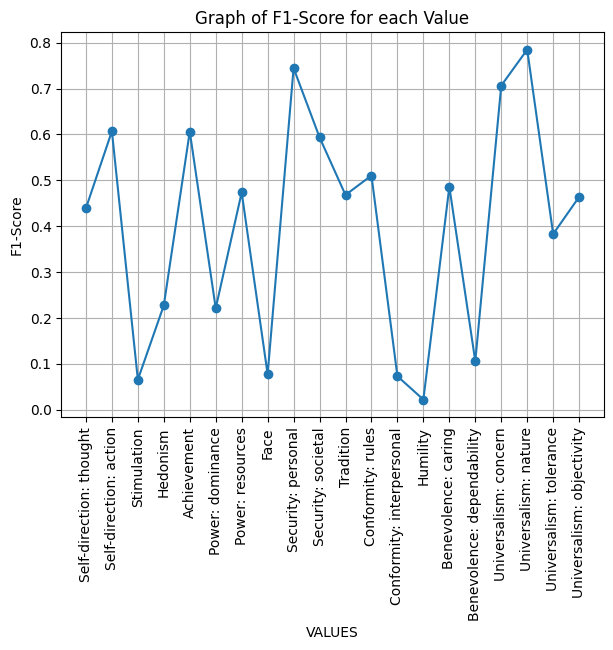

In [20]:
plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Graph of F1-Score for each Value')

plt.grid(True)
plt.show()